# From VHF sources to lightning flashes

Using space-time criteria, we will group LMA data into flashes. We will also create a 2D gridded version of these flash data to look at VHF source density, flash extent density, and average flash area. 

Background reading: [Bruning and MacGorman (2013, JAS)](http://dx.doi.org/10.1175/JAS-D-12-0289.1) show how flash area is defined from the convex hull of the VHF point sources (Fig. 2) and show what flash extent density and average flash area look like for a supercell (Fig. 4). We'll use the same definitions here.

In [1]:
import glob
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import pyproj as proj4

from pyxlma.lmalib.io import read as lma_read
from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats, filter_flashes
from pyxlma.lmalib.grid import  create_regular_grid, assign_regular_bins, events_to_grid
from pyxlma.plot.xlma_plot_feature import color_by_time, plot_points, setup_hist, plot_3d_grid, subset
from pyxlma.plot.xlma_base_plot import subplot_labels, inset_view, BlankPlot

import sys, glob

from lmalibtracer.coords.sbu import get_sbu_proj as get_coord_proj

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt

## Configurable Parameters 

These are the parameters that will be used by the flash sorting and gridding algorithms - it's a fairly small list.

These parameters are the ones we would expect to adjust when controlling for noise. We also require that a flash have more than one point!



In [4]:
filenames = glob.glob('/data/Houston/130619/LYLOUT_130619_2[0-1]*.dat.gz')

In [5]:
# Adjust this to match the length of the dataset we read in. It is used to set up 
# the total duration of the gridding along the time dimension.
duration_min = 120

# Source to flash 
chi2max = 1.0
stationsmin = 6
min_events_per_flash = 5

# There is a parameter to change the gridding from the 1 min default time resolution.
grid_time_delta_sec = 60
resolution_m = 1000
latlon_grid=False # False uses the stereographic coordinate grid.

## Read VHF source data and identify flashes

Includes filtering by flash event count.

In [6]:
print("Reading files")
lma_data, starttime = lma_read.dataset(filenames)
good_events = (lma_data.event_stations >= stationsmin) & (lma_data.event_chi2 <= chi2max)
lma_data = lma_data[{'number_of_events':good_events}]

dttuple = [starttime, starttime+datetime.timedelta(minutes=duration_min)]
# dttuple = lma_data.Datetime.min(), lma_data.Datetime.max()
tstring = 'LMA {}-{}'.format(dttuple[0].strftime('%H%M'),
                                  dttuple[1].strftime('%H%M UTC %d %B %Y '))
print(tstring)

print("Clustering flashes")
ds = cluster_flashes(lma_data)
print("Calculating flash stats")
ds = flash_stats(ds)
ds = filter_flashes(ds, flash_event_count=(min_events_per_flash, None))
# ds0 = ds.copy()
print(ds)

Reading files
LMA 2000-2200 UTC 19 June 2013 
Clustering flashes
Calculating flash stats
<xarray.Dataset>
Dimensions:                              (number_of_events: 219640, number_of_flashes: 4308, number_of_stations: 13)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 3 ... 8190
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude              float64 29.76
    network_center_longitude             float64 -95.37
    network_center_altitude              float64 -200.0
    station_latitude                     (number_of_stations) float32 29.9392...
    station_longitude                    (number_of_stations) float32 -95.646...
    station_altitude                     (number_of_stations) float32 31.6600...
    station_event_fraction               (number_of_stations) float32 37154.0...
    station_power_ratio                  (number_of_stations) float32 1.02083...
    event_latitude          

## Contents of the flash-sorted LMA data structure.

Once the cell above finishes running, you'll see that our LMA data structure has grown. There is a new `number_of_flashes` dimension, and associated flash data variables. We still have all of the events, but they have been filtered to be just the ones that meet the stations and chi_2 criteria.

Perhaps the most important two variables in terms of understanding the data are the `event_parent_flash_id` and `flash_id` variables. Their dimensions are `number_of_events` and `number of flashes`, respectively. Each flash has a unique `flash_id`, an unsigned integer, and then each event in that flash is labled with that integer. Therefore, those two variables define which events go with which flashes, and let us pair up flash-level statstics (such as `flash_area`) with the events used to calculate those statistics.

In [7]:
print(ds.event_parent_flash_id)
print('-----')
print('-----')
print(ds.flash_id)

<xarray.DataArray 'event_parent_flash_id' (number_of_events: 219640)>
array([   3,    3,    3, ..., 8190, 8190, 8190], dtype=uint64)
Dimensions without coordinates: number_of_events
Attributes:
    _FillValue:   18446744073709551615
    cf_role:      tree_id
    coordinates:  event_id
-----
-----
<xarray.DataArray 'flash_id' (number_of_flashes: 4308)>
array([   3, 8196, 8197, ..., 8187, 8188, 8190], dtype=uint64)
Coordinates:
  * number_of_flashes  (number_of_flashes) uint64 3 8196 8197 ... 8187 8188 8190


Let's see how many events are in our flashes. We can also check for an expected correlation: do the number of events increase with flash area?

[   0    1    3    7   15   31   63  127  255  511 1023 2047]


[]

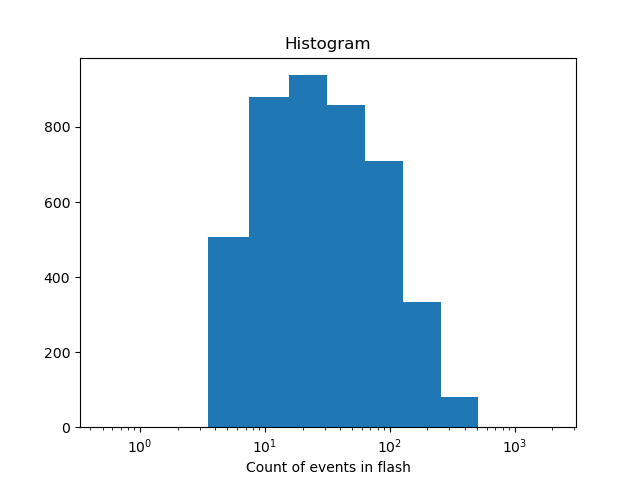

In [8]:
event_count_bins = 2**np.arange(12)-0.5
print(event_count_bins.astype(int))
fig, ax = plt.subplots(1,1)
art = ds.flash_event_count.plot.hist(bins=event_count_bins, ax=ax)
ax.semilogx()

[   0    1    3    7   15   31   63  127  255  511 1023 2047]


[]

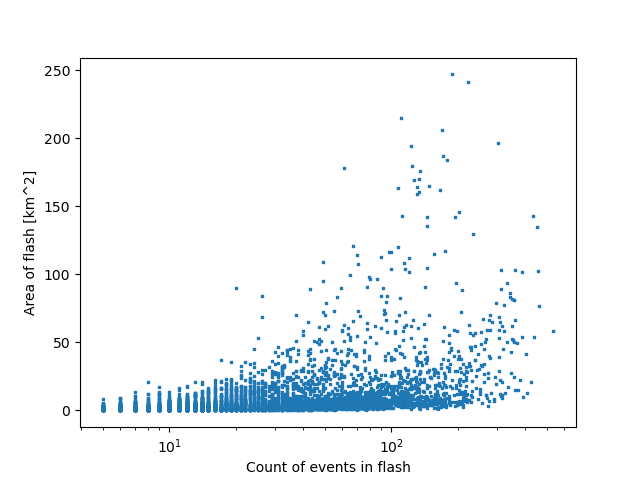

In [9]:
event_count_bins = 2**np.arange(12)-0.5
print(event_count_bins.astype(int))
fig, ax = plt.subplots(1,1)
art = ds.plot.scatter('flash_event_count', 'flash_area', marker='s', s=1, ax=ax)
ax.semilogx()

## Plot the VHF event data

xlma-python has built-in plotting capabilities to make a standard plot style that has a plan view, two vertical projections, and a time height view of the events.

We don't actually need the flash-sorted data, but it doesn't hurt to have it in the dataset.

In [10]:
alt_data = ds.event_altitude.values/1000.0
lon_data = ds.event_longitude.values
lat_data = ds.event_latitude.values
time_data = pd.Series(ds.event_time) # because time comparisons
chi_data = ds.event_chi2.values
station_data = ds.event_stations.values

# Plot color map and marker size
plot_cmap = 'plasma'
plot_s = 5

/Users/ebruning/miniconda3/envs/lmatracer/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:762: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7ffd693f0350> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


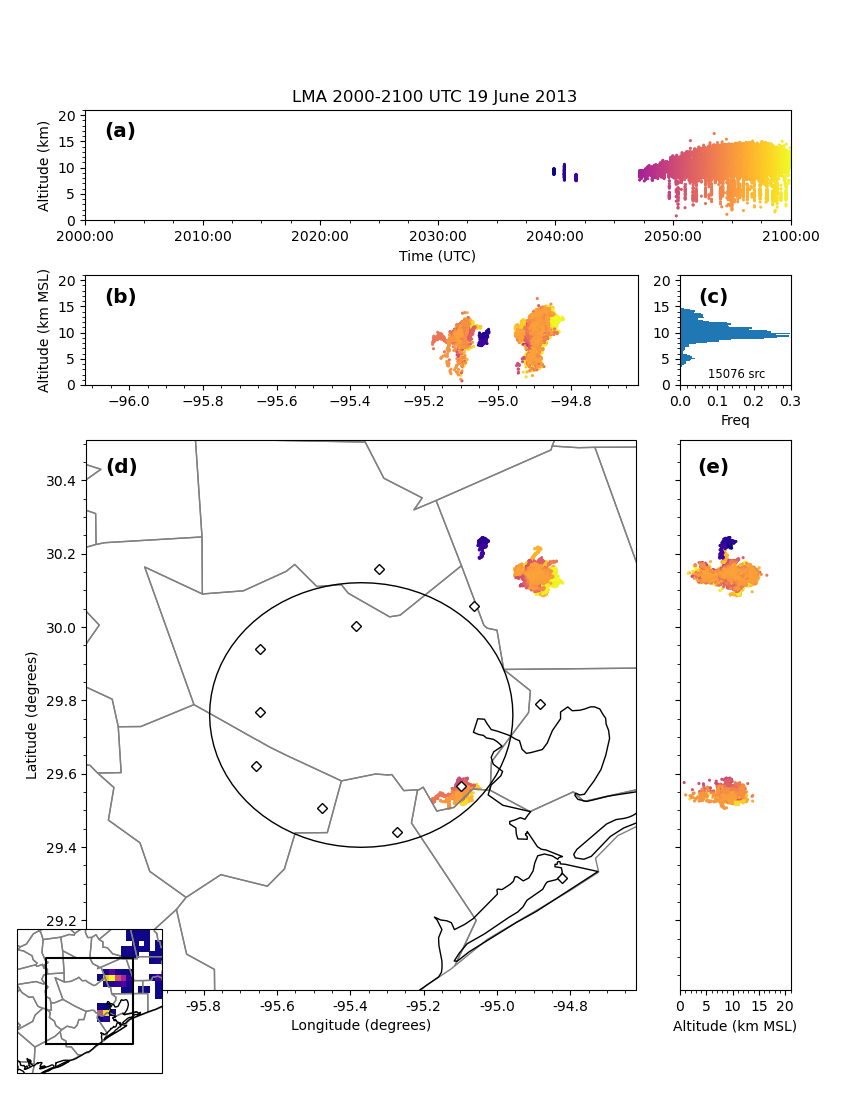

In [11]:

tlim_sub = [pd.to_datetime(starttime), pd.to_datetime(pd.to_datetime(starttime) + np.asarray(60, 'timedelta64[m]'))]
tstring = 'LMA {}-{}'.format(tlim_sub[0].strftime('%H%M'),
                             tlim_sub[1].strftime('%H%M UTC %d %B %Y '))

clat, clon = float(lma_data.network_center_latitude), float(lma_data.network_center_longitude)
xlim = [clon-0.75, clon+0.75]
ylim = [clat-0.75, clat+0.75]
zlim = [0, 21]
xchi = 1.0
stationmin = 6.0

lon_set, lat_set, alt_set, time_set, selection = subset(
           lon_data, lat_data, alt_data, time_data, chi_data, station_data,
           xlim, ylim, zlim, tlim_sub, xchi, stationmin)

bk_plot = BlankPlot(pd.to_datetime(tlim_sub[0]), bkgmap=True, 
              xlim=xlim, ylim=ylim, zlim=zlim, tlim=tlim_sub, title=tstring)

# Add a view of where the subset is
xdiv = ydiv = 0.1
inset_view(bk_plot, lon_data, lat_data, xlim, ylim, xdiv, ydiv,
          buffer=0.5, inset_size=0.15, plot_cmap = 'plasma', bkgmap = True)
# Add some subplot labels
subplot_labels(bk_plot)
# Add a range ring
bk_plot.ax_plan.tissot(rad_km=40.0, lons=clon, lats=clat, n_samples=80,
                  facecolor='none',edgecolor='k')
# Add the station locations
stn_art = bk_plot.ax_plan.plot(lma_data['station_longitude'], 
                               lma_data['station_latitude'], 'wD', mec='k', ms=5)

if len(lon_set)==0:
    bk_plot.ax_hist.text(0.02,1,'No Sources',fontsize=12)
else:
    plot_vmin, plot_vmax, plot_c = color_by_time(time_set, tlim_sub)
    plot_points(bk_plot, lon_set, lat_set, alt_set, time_set,
                      plot_cmap, plot_s, plot_vmin, plot_vmax, plot_c)

plt.show()

# We can save a publication-ready plot using this line … and you can change to .pdf to get a vector plot.
# plt.savefig('./images/' + dttuple[0].strftime('%y%m%d') +
#             '/relampago_points_' + dttuple[0].strftime('%Y%m%d_%H%M.png'))

## Saving the data … or not

At this stage we could save the flash-sorted data to a NetCDF file. However, we're going to pass on that step right now, in favor of adding a basic gridded dataset to our saved file.

In [12]:
if False:
    print("Writing data")
    duration_sec = (dttuple[1]-dttuple[0]).total_seconds()
    date_fmt = "LYLOUT_%y%m%d_%H%M%S_{0:04d}_flash.nc".format(int(duration_sec))
    outfile = dttuple[0].strftime(date_fmt)

    # Compress the variables.
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars}
    ds.to_netcdf(outfile, encoding=encoding)

Above, we set `latlon_grid = False`; instead, let's use the 500 m stereographic grid defined by Stony Brook University's cell-tracking team. It's [defined in lmalibtracer](https://github.com/deeplycloudy/lmalib-tracer/blob/main/lmalibtracer/coords/sbu.py) and was imported above. The definition is not too complicated - it only requires specifying the radious of a spherical earth and a coordinate center location in addition. All the other coordinate transformations are handled for us by `pyproj`.

The next block of code is a bit long, mainly beause we have repeated the blocks for defining the grid two ways. Note that we could uncomment a few lines and create a 3D grid, too. But it's useful to have flash extent density as a 2D instead of 3D analysis for quick-look visualizations, and it's also sufficient for most of our science.

In [13]:
print("Setting up grid spec")
grid_dt = np.asarray(grid_time_delta_sec, dtype='m8[s]')
grid_t0 = np.asarray(dttuple[0]).astype('datetime64[ns]')
grid_t1 = np.asarray(dttuple[1]).astype('datetime64[ns]')
time_range = (grid_t0, grid_t1+grid_dt, grid_dt)

# Change the dictionaries below to a consistent set of coordinates
# and adjust grid_spatial_coords in the call to events_to_grid to
# change what is gridded (various time series of 1D, 2D, 3D grids)

if latlon_grid:
    # Houston
    # center = 29.7600000, -95.3700000
    lat_range = (27.75, 31.75, 0.025)
    lon_range = (-97.37, -93.37, 0.025)
    alt_range = (0, 18e3, 1.0e3)


    grid_edge_ranges ={
        'grid_latitude_edge':lat_range,
        'grid_longitude_edge':lon_range,
    #     'grid_altitude_edge':alt_range,
        'grid_time_edge':time_range,
    }
    grid_center_names ={
        'grid_latitude_edge':'grid_latitude',
        'grid_longitude_edge':'grid_longitude',
    #     'grid_altitude_edge':'grid_altitude',
        'grid_time_edge':'grid_time',
    }

    event_coord_names = {
        'event_latitude':'grid_latitude_edge',
        'event_longitude':'grid_longitude_edge',
    #     'event_altitude':'grid_altitude_edge',
        'event_time':'grid_time_edge',
    }

    flash_ctr_names = {
        'flash_init_latitude':'grid_latitude_edge',
        'flash_init_longitude':'grid_longitude_edge',
    #     'flash_init_altitude':'grid_altitude_edge',
        'flash_time_start':'grid_time_edge',
    }
    flash_init_names = {
        'flash_center_latitude':'grid_latitude_edge',
        'flash_center_longitude':'grid_longitude_edge',
    #     'flash_center_altitude':'grid_altitude_edge',
        'flash_time_start':'grid_time_edge',
    }
else:
    # Project lon, lat to SBU map projection
    sbu_lla, sbu_map, x_edge, y_edge = get_coord_proj()
    sbu_dx = x_edge[1] - x_edge[0]
    sbu_dy = y_edge[1] - y_edge[0]
    lma_sbu_xratio = resolution_m/sbu_dx
    lma_sbu_yratio = resolution_m/sbu_dy
    trnsf_to_map = proj4.Transformer.from_crs(sbu_lla, sbu_map)
    trnsf_from_map = proj4.Transformer.from_crs(sbu_map, sbu_lla)
    lmax, lmay = trnsf_to_map.transform(#sbu_lla, sbu_map,
                                 ds.event_longitude.data,
                                 ds.event_latitude.data)
    lma_initx, lma_inity = trnsf_to_map.transform(#sbu_lla, sbu_map,
                                 ds.flash_init_longitude.data,
                                 ds.flash_init_latitude.data)
    lma_ctrx, lma_ctry = trnsf_to_map.transform(#sbu_lla, sbu_map,
                                 ds.flash_center_longitude.data,
                                 ds.flash_center_latitude.data)
    ds['event_x'] = xr.DataArray(lmax, dims='number_of_events')
    ds['event_y'] = xr.DataArray(lmay, dims='number_of_events')
    ds['flash_init_x'] = xr.DataArray(lma_initx, dims='number_of_flashes')
    ds['flash_init_y'] = xr.DataArray(lma_inity, dims='number_of_flashes')
    ds['flash_ctr_x'] = xr.DataArray(lma_ctrx, dims='number_of_flashes')
    ds['flash_ctr_y'] = xr.DataArray(lma_ctry, dims='number_of_flashes')

    grid_edge_ranges ={
        'grid_x_edge':(x_edge[0],x_edge[-1]+.001,sbu_dx*lma_sbu_xratio),
        'grid_y_edge':(y_edge[0],y_edge[-1]+.001,sbu_dy*lma_sbu_yratio),
    #     'grid_altitude_edge':alt_range,
        'grid_time_edge':time_range,
    }
    grid_center_names ={
        'grid_x_edge':'grid_x',
        'grid_y_edge':'grid_y',
    #     'grid_altitude_edge':'grid_altitude',
        'grid_time_edge':'grid_time',
    }

    event_coord_names = {
        'event_x':'grid_x_edge',
        'event_y':'grid_y_edge',
    #     'event_altitude':'grid_altitude_edge',
        'event_time':'grid_time_edge',
    }

    flash_ctr_names = {
        'flash_init_x':'grid_x_edge',
        'flash_init_y':'grid_y_edge',
    #     'flash_init_altitude':'grid_altitude_edge',
        'flash_time_start':'grid_time_edge',
    }
    flash_init_names = {
        'flash_ctr_x':'grid_x_edge',
        'flash_ctr_y':'grid_y_edge',
    #     'flash_center_altitude':'grid_altitude_edge',
        'flash_time_start':'grid_time_edge',
    }


print("Creating regular grid")
grid_ds = create_regular_grid(grid_edge_ranges, grid_center_names)
if latlon_grid:
    pass
else:
    ctrx, ctry = np.meshgrid(grid_ds.grid_x, grid_ds.grid_y)
    hlon, hlat = trnsf_from_map.transform(ctrx, ctry)
    # Add lon lat to the dataset, too.
    ds['lon'] = xr.DataArray(hlon, dims=['grid_y', 'grid_x'],
                    attrs={'standard_name':'longitude'})
    ds['lat'] = xr.DataArray(hlat, dims=['grid_y', 'grid_x'],
                    attrs={'standard_name':'latitude'})

print("Finding grid position for flashes")
pixel_id_var = 'event_pixel_id'
ds_ev = assign_regular_bins(grid_ds, ds, event_coord_names,
    pixel_id_var=pixel_id_var, append_indices=True)
# ds_flctr = assign_regular_bins(grid_ds, ds, flash_ctr_names,
#     pixel_id_var='flash_ctr_pixel_id', append_indices=True)
# flctr_gb = ds.groupby('flash_ctr_pixel_id')
# ds_flini = assign_regular_bins(grid_ds, ds, flash_init_names,
#     pixel_id_var='flash_init_pixel_id', append_indices=True)
# flini_gb = ds.groupby('flash_init_pixel_id')

# print('===== ev_gb')
# for event_pixel_id, dsegb in ev_gb:
#     print(dsegb)
#     break
# print('===== flctr_gb')
# for event_pixel_id, dsfgb in flctr_gb:
#     print(dsfgb)
#     break

print("Gridding data")
if latlon_grid:
    grid_spatial_coords=['grid_time', None, 'grid_latitude', 'grid_longitude']
    event_spatial_vars = ('event_altitude', 'event_latitude', 'event_longitude')
else:
    grid_spatial_coords=['grid_time', None, 'grid_y', 'grid_x']
    event_spatial_vars = ('event_altitude', 'event_y', 'event_x')

# print(ds_ev)
# print(grid_ds)
grid_ds = events_to_grid(ds_ev, grid_ds, min_points_per_flash=3,
                         pixel_id_var=pixel_id_var,
                         event_spatial_vars=event_spatial_vars,
                         grid_spatial_coords=grid_spatial_coords)

Setting up grid spec
Creating regular grid
Finding grid position for flashes
Gridding data


In [14]:
# Let's combine the flash and event data with the gridded data into one giant data structure.
both_ds = xr.combine_by_coords((grid_ds, ds))
print(both_ds)

<xarray.Dataset>
Dimensions:                              (grid_time: 120, grid_time_edge: 121, grid_x: 250, grid_x_edge: 251, grid_y: 250, grid_y_edge: 251, number_of_events: 219640, number_of_flashes: 4308, number_of_stations: 13)
Coordinates:
  * grid_x                               (grid_x) float64 -1.245e+05 ... 1.24...
  * grid_y                               (grid_y) float64 -1.245e+05 ... 1.24...
  * grid_x_edge                          (grid_x_edge) float64 -1.25e+05 ... ...
  * grid_y_edge                          (grid_y_edge) float64 -1.25e+05 ... ...
  * grid_time_edge                       (grid_time_edge) datetime64[ns] 2013...
  * grid_time                            (grid_time) datetime64[ns] 2013-06-1...
  * number_of_flashes                    (number_of_flashes) uint64 3 ... 8190
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    flash_extent_density                 (grid_time, grid_y, grid_x) float64 ...
    average_flash_area 

## Looking at the gridded data

Once the cells above have been run, a new data structure (`both_ds`) will have the events, flashes, and their gridded versions. Note the new dimensions for the center and edges of the grid boxes (`grid_time: 24, grid_time_edge: 25, grid_x: 250, grid_x_edge: 251, grid_y: 250, grid_y_edge: 251`), and the new variables like `flash_extent_density` with dimensions `(grid_time, grid_y, grid_x)`.

Let's plot flash extent density for the 42nd time step!

['2013-06-19T20:42:00.000000000' '2013-06-19T20:43:00.000000000']


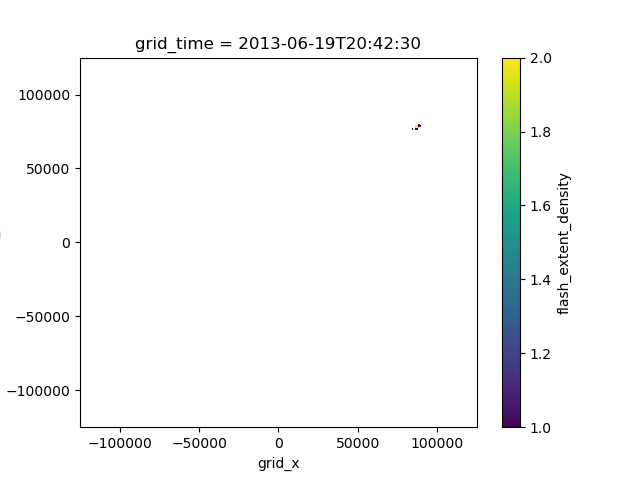

In [15]:
time_idx = 42
fig, ax = plt.subplots(1,1)
both_ds.flash_extent_density[time_idx, :, :].plot.imshow(ax=ax)
print(both_ds.grid_time_edge[time_idx:time_idx+2].data)

### Add widget interactivity

It's a bit tedious to change the time index manually. Let's[Interact!](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). It's possible to build much nicer interfaces, but this is enough for a quick look.

In [16]:
both_ds.dims['grid_time']

120

interactive(children=(IntSlider(value=0, description='time_idx', max=119), Output()), _dom_classes=('widget-in…

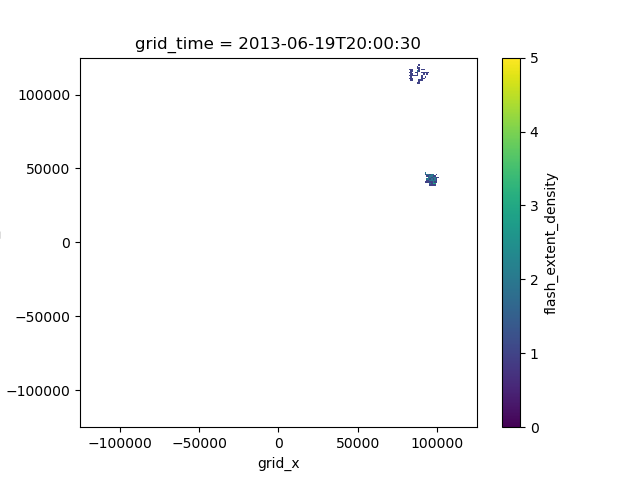

In [17]:
from ipywidgets import interact #, interactive, fixed, interact_manual
fig = plt.figure()

n_times = both_ds.dims['grid_time']
@interact(time_idx=(0, n_times-1))
def plot(time_idx=0):
    fig.clear()
    ax = fig.add_subplot(1,1,1)
    both_ds.flash_extent_density[time_idx, :, :].plot.imshow(ax=ax, vmin=0, vmax=5)

## Aggregating in time
With these low flash rates, it's hard to get a sense of everything in the dataset, so let's sum across the time dimension. (`xarray` also has a rolling window function.)

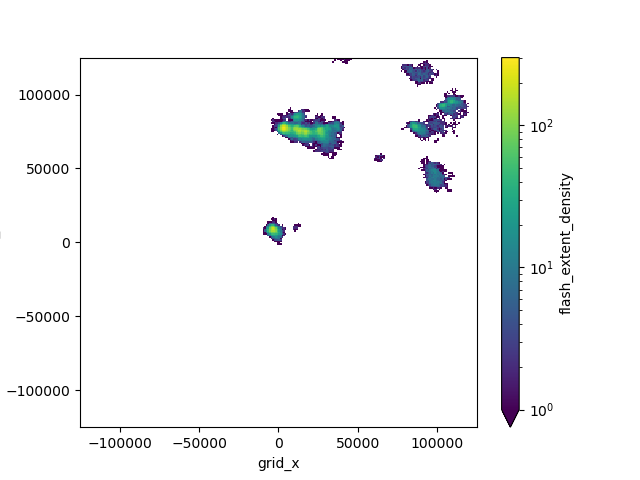

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
from matplotlib.colors import LogNorm
both_ds.flash_extent_density.sum('grid_time').plot.imshow(ax=ax, norm=LogNorm(1, 300))

## Finally, write the data.

Once we save the data to disk, we can reload the data an re-run any of the plots above without reprocessing everything. We'll make files like this from the post-processed LMA data for each day during ESCAPE/TRACER, and they will be one of our data deliverables to the NCAR EOL catalog, in accordance with the ESCAPE data management plan as proposed in the grant.

In [ ]:
if True:
    print("Writing data")
    duration_sec = (dttuple[1]-dttuple[0]).total_seconds()
    if latlon_grid:
        date_fmt = "LYLOUT_%y%m%d_%H%M%S_{0:04d}_grid.nc".format(int(duration_sec))
    else:
        date_fmt = "LYLOUT_%y%m%d_%H%M%S_{0:04d}_map{1:d}m.nc".format(
                        int(duration_sec), resolution_m)
    outfile = dttuple[0].strftime(date_fmt)

    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in both_ds.data_vars}
    both_ds.to_netcdf(outfile, encoding=encoding)